# Basic Objects in ObsPy

ObsPy provides several fundamental objects (classes) that form the foundation for most seismic data handling and processing tasks. These objects allow efficient reading, manipulation, and analysis of seismic data.

## 1. UTCDateTime
- This is ObsPy's custom date/time object.
- It's used for handling date and time operations in seismological data, which often requires precise timing.
     
## 2. Trace
- A Trace object represents a single, continuous time series in seismology.
- It contains the actual time series data as well as metadata (like station information, channel, start time, etc.).

## 3. Event Inventory
- Stores information about seismic events
- Includes origin, magnitude, and pick data
- Organized in Catalog object containing multiple Event objects

![Event Inventory Structure](images/Event.svg)

## 4. Station Inventory
- Hierarchical structure: Network > Station > Channel
- Contains metadata about seismic stations
- Accessed via Inventory object

![Station Inventory Structure](images/Inventory.svg)

## 5. Stream
- A Stream is a container for multiple Trace objects.
- It allows you to group related traces together and perform operations on them collectively.
  
![Stream and Trace Structure](images/Stream_Trace.svg)


### 1. Writing a function to download waveforms

Write a function and use it to get the data for broadband stations within 200 km of the 2009 Dusky Sound Magnitude 7.8 earthquake, and plot the waveforms. Do you see the same clipping of high amplitudes that we saw with the Kaikoura earthquake?

You can also try getting data from the strong motion stations (that have channel codes HN?) and see if they clip or not.

In [1]:
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client

def get_data_for_event(event_id, client, maxradius, duration):
    """
    Get data for broadband stations within maxradius of an event.
    
    Parameters
    ----------
    event_id : str
        event-id to get data for
    client : str or obspy.clients.fdsn.Client
        FDSN client to get data from
    maxradius : float
        Maximum radius to get stations for in degrees
    duration : float
        Duration to download in seconds
        
    Returns
    -------
    obspy.Stream
        Stream containing waveform data
    """
    # Ensure client is an ObsPy Client object
    if isinstance(client, str):
        client = Client(client)

    # Download the event of interest
    cat = client.get_events(eventid=event_id)
    event = cat[0]
    
    # Get event parameters
    origin_time = event.origins[0].time
    latitude = event.origins[0].latitude
    longitude = event.origins[0].longitude
    
    # Set time window
    starttime = origin_time
    endtime = starttime + duration

    # Get the stations within maxradius of the event origin and operational during the time window of interest
    inv = client.get_stations(starttime=starttime, endtime=endtime,
                              latitude=latitude, longitude=longitude,
                              maxradius=maxradius, channel="HH*")
    
    # Download the waveforms for those stations
    st = Stream()
    for network in inv:
        for station in network:
            try:
                st += client.get_waveforms(network.code, station.code, "*", "HH?",
                                           starttime, endtime)
            except Exception as e:
                print(f"Error downloading data for {network.code}.{station.code}: {e}")
    
    # Return the Stream
    return st

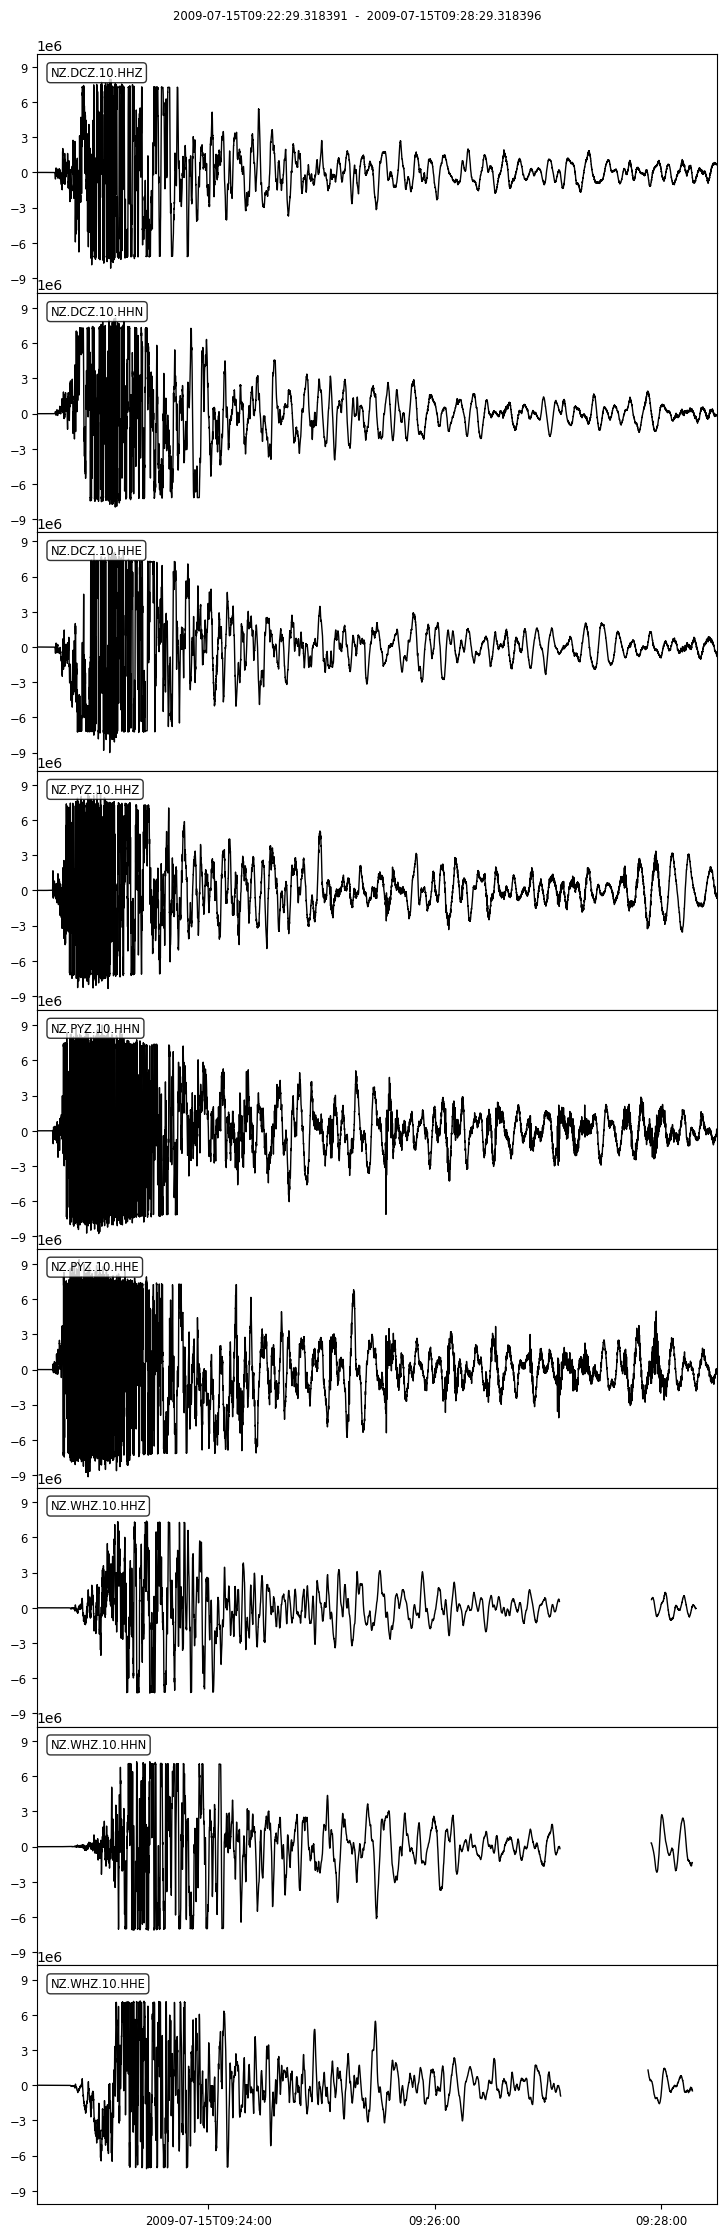

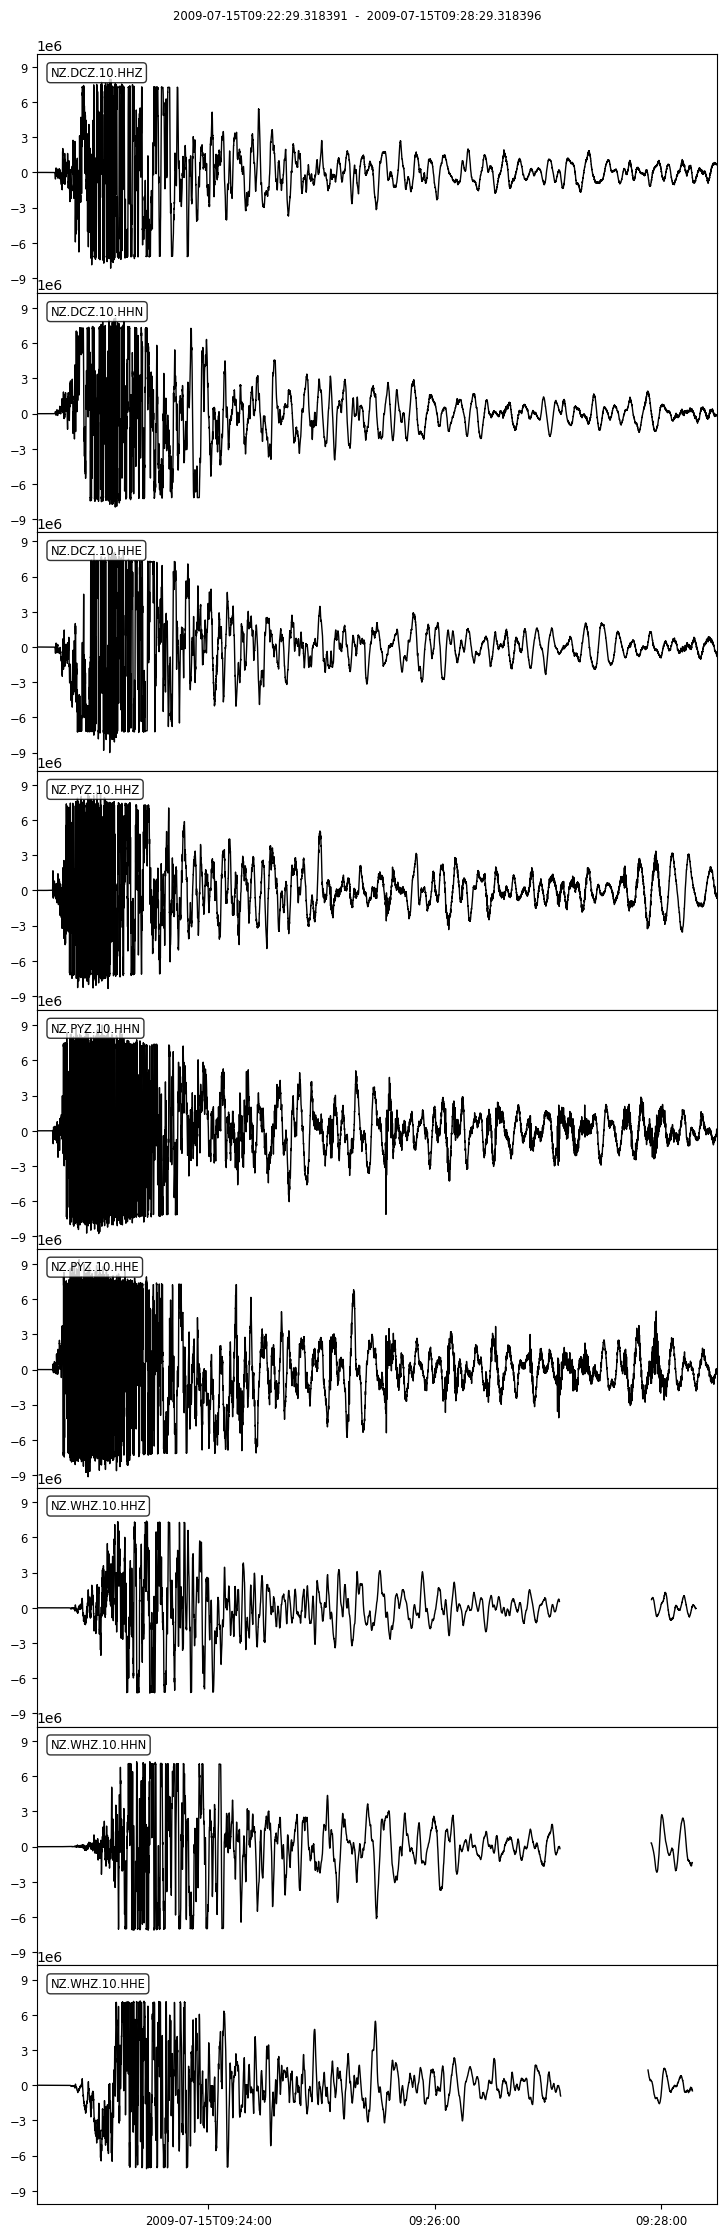

In [2]:
client_geonet = Client("GEONET")
waveform = get_data_for_event(event_id=3124785,client=client_geonet, maxradius=1, duration=360)
waveform.plot()

### 2. The final exercise:

- Download data for stations within 1 degree of GeoNet event 2023p122368, around the event time
- Filter the data between 1 and 20 Hz
- Resample the data to a 50 Hz sampling rate
- Plot the data
- Plot the spectrogram
- Compare the frequency content at each station qualitatively.

-------
Plot data
-------


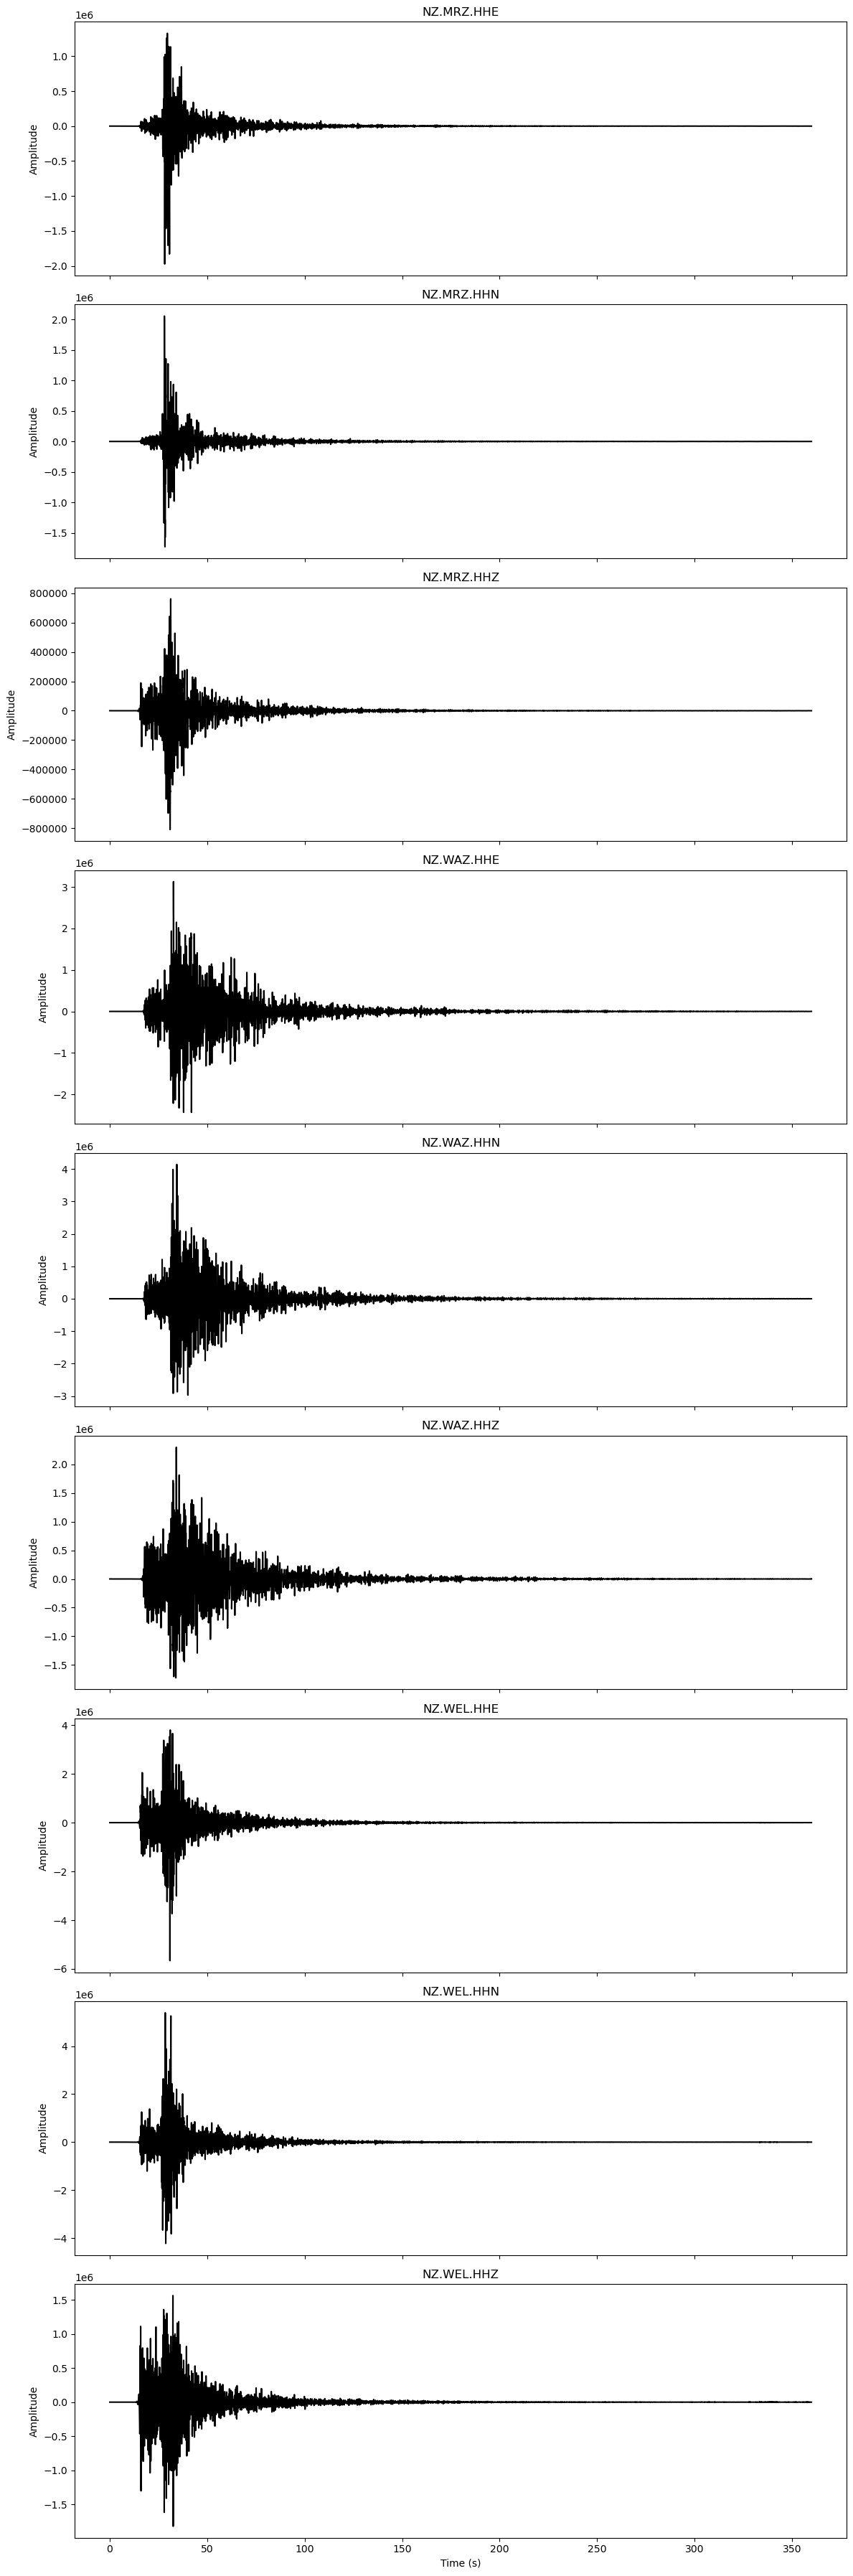

-------
Plot and compare frequency content
-------


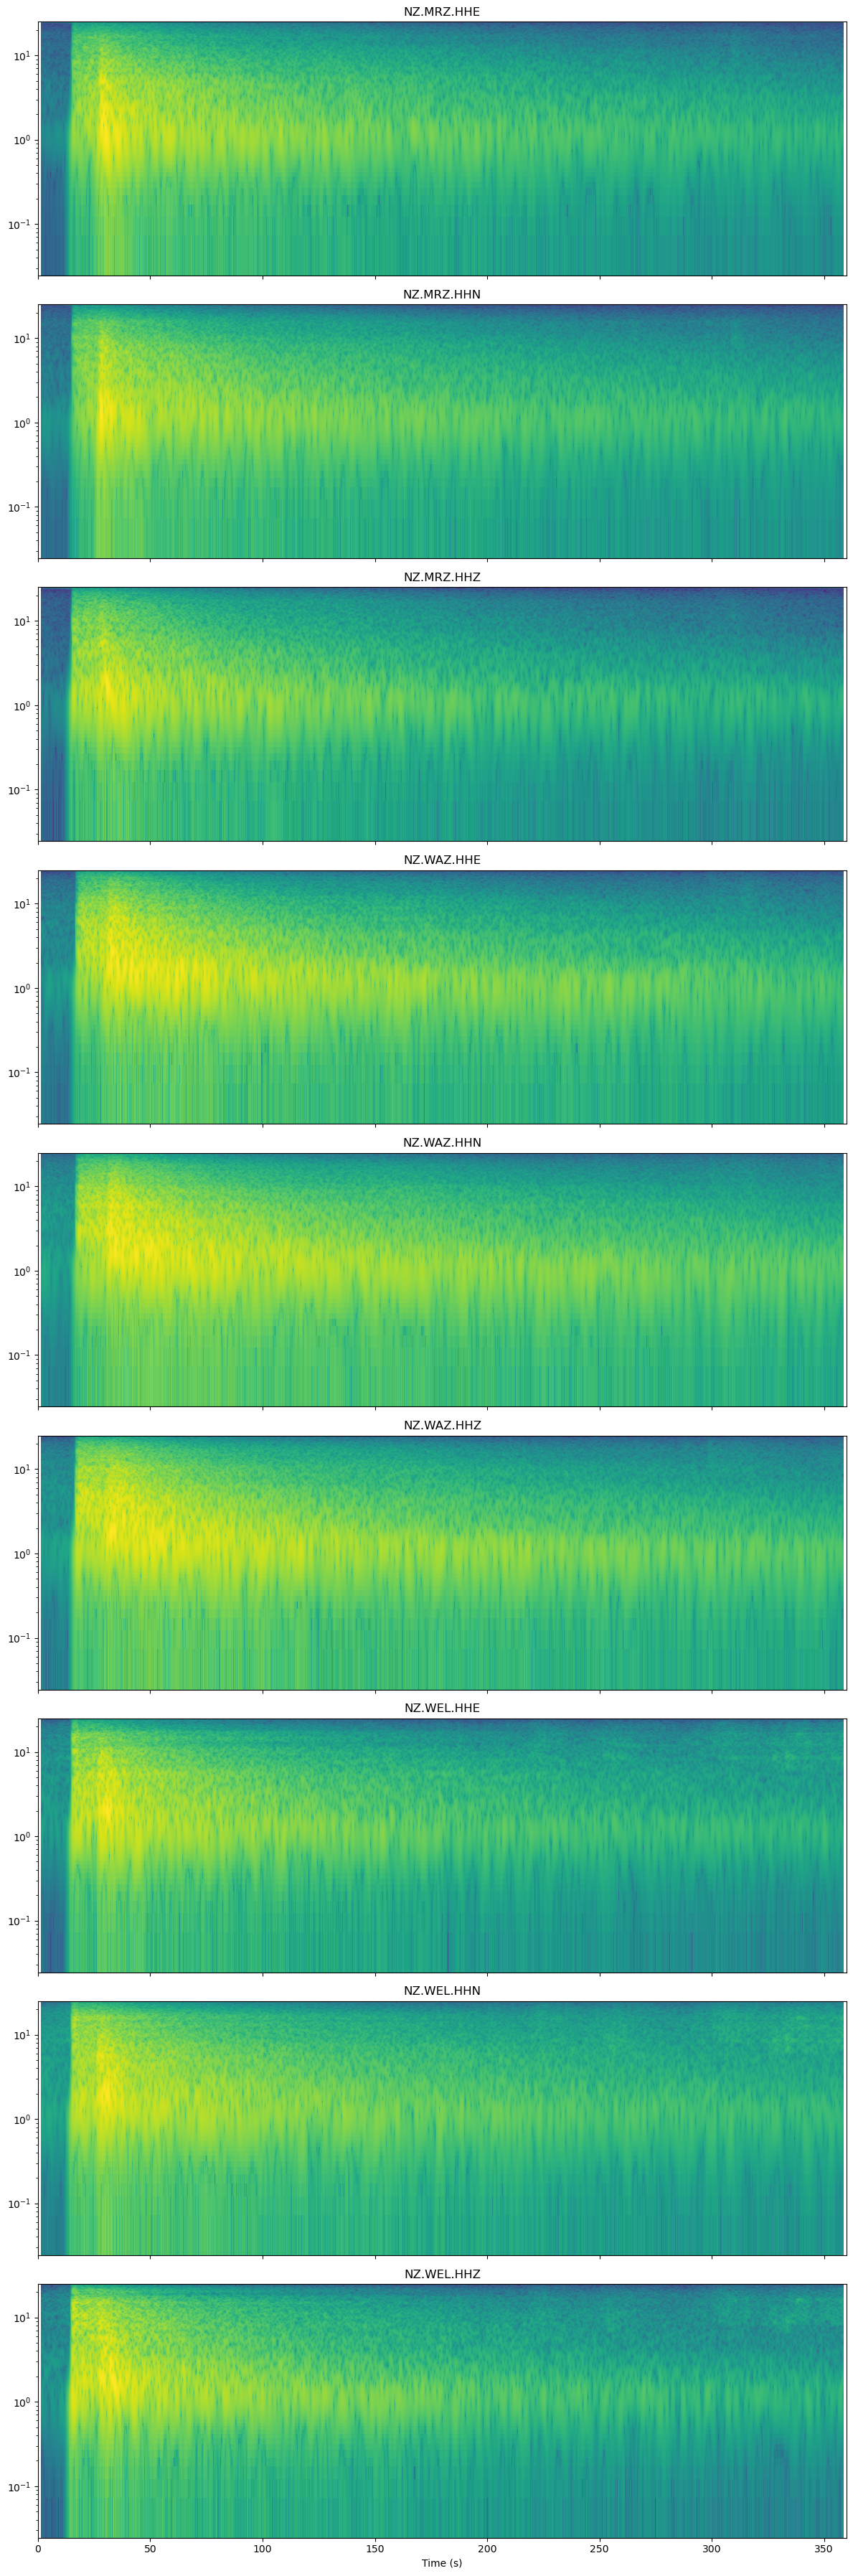

In [3]:
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt

# Set up parameters
event_id = "2023p122368"
client = Client("GEONET")
maxradius = 1  # degree
duration = 360  # seconds (6 minutes)

# Download data
st = get_data_for_event(event_id, client, maxradius, duration)

# Process the data
st.detrend("linear")

# Filter the data between 1 and 20 Hz
st.filter("bandpass", freqmin=1, freqmax=20, corners=4, zerophase=True)

#Resample the data to a 50 Hz sampling rate
st.resample(50)  # Resample to 50 Hz

# Plot the data
print("-------")
print("Plot data")
print("-------")
fig, axs = plt.subplots(len(st), 1, figsize=(12, 4*len(st)), sharex=True)
for i, tr in enumerate(st):
    axs[i].plot(tr.times(), tr.data, 'k')
    axs[i].set_title(f"{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}")
    axs[i].set_ylabel("Amplitude")
axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

# Plot and compare frequency content
print("-------")
print("Plot and compare frequency content")
print("-------")
fig, axs = plt.subplots(len(st), 1, figsize=(12, 4*len(st)), sharex=True, sharey=True)
for i, tr in enumerate(st):
    tr.spectrogram(log=True, dbscale=True, axes=axs[i], show=False)
    axs[i].set_title(f"{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}")
axs[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()